In [4]:
device = "cuda"
import lightgbm as lgb
import torch
import torch.nn as nn
# load tree model
lgbm_model = lgb.Booster(model_file='lgbm_model.txt')

# load lstm model
class LSTMClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers=1, dropout=0.3):
        super(LSTMClassifier, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.dropout = nn.Dropout(dropout)
        self.fc1 = nn.Linear(hidden_dim, 32)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(32, output_dim)

    def forward(self, x):
        _, (h_n, _) = self.lstm(x)  # take last hidden state
        x = h_n[-1]
        x = self.dropout(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x
lstm_model = LSTMClassifier(input_dim=32, hidden_dim=128, output_dim=3, num_layers = 2).to(device)
lstm_model.load_state_dict(torch.load('lstm_model_long.pth'))


class TimeSeriesTransformer(nn.Module):
    def __init__(self, input_dim, model_dim=64, num_heads=4, num_layers=2, num_classes=3, dropout=0.1):
        super().__init__()
        self.model_dim = model_dim
        self.input_proj = nn.Linear(input_dim, model_dim)
        self.pos_encoder = PositionalEncoding(model_dim, dropout)

        encoder_layers = nn.TransformerEncoderLayer(d_model=model_dim, nhead=num_heads, dropout=dropout, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_layers=num_layers)

        self.classifier = nn.Sequential(
            nn.Linear(model_dim, model_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(model_dim, num_classes)
        )

    def forward(self, x):
        # x: (batch_size, seq_len, input_dim)
        x = self.input_proj(x)  # -> (batch_size, seq_len, model_dim)
        x = self.pos_encoder(x)
        x = self.transformer_encoder(x)  # -> (batch_size, seq_len, model_dim)
        x = x.mean(dim=1)  # global average pooling over time
        out = self.classifier(x)
        return out

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=500):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)
        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-torch.log(torch.tensor(10000.0)) / d_model))
        pe = torch.zeros(1, max_len, d_model)
        pe[0, :, 0::2] = torch.sin(position * div_term)
        pe[0, :, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:, :x.size(1)]
        return self.dropout(x)

transformer_model = TimeSeriesTransformer(input_dim=32, num_classes=3)
transformer_model.load_state_dict(torch.load("transformer_model_long.pth"))
transformer_model.to(device)
transformer_model.eval()


/tmp/ipykernel_1444534/3456013814.py:28: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  lstm_model.load_state_dict(torch.load('lstm_model_long.pth'))
/tmp/ipykernel_1444534/3

TimeSeriesTransformer(
  (input_proj): Linear(in_features=32, out_features=64, bias=True)
  (pos_encoder): PositionalEncoding(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-1): 2 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
        )
        (linear1): Linear(in_features=64, out_features=2048, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=2048, out_features=64, bias=True)
        (norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (classifier): Sequential(
    (0): Linear(in_features=64, out_features=64, bias=True)
    (1): ReLU()
    (2)

we have to redo the dataset part for evaluation. 

In [7]:
import os
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler

def generate_lstm_dataset(input_dir="data/labeled_features",
                          output_file=None,
                          window_size=60):

    always_ignore = {
        'Date', 'Ticker', 'Label',
        'EPS_TTM', 'PE_Ratio', 'Dividend_Yield',
        'Market_Cap', 'ForwardReturn', 'VolThreshold'
    }

    X_all, y_all, dates_all, tickers_all = [], [], [], []
    files = [f for f in os.listdir(input_dir) if f.endswith(".csv")]

    print(f"📂 Found {len(files)} labeled CSVs in {input_dir}")
    print(f"🧹 Ignoring columns: {sorted(always_ignore)}\n")

    for i, file in enumerate(files):
        ticker = file.replace(".csv", "").replace("_train", "").replace("_test", "")
        path = os.path.join(input_dir, file)

        try:
            df = pd.read_csv(path, parse_dates=['Date'])
            feature_cols = [c for c in df.columns if c not in always_ignore]

            df = df.dropna(subset=feature_cols + ['Label']).reset_index(drop=True)
            if len(df) < window_size + 1:
                print(f"[{i+1}/{len(files)}] ⚠️ Skipped {ticker} (not enough data, rows={len(df)})")
                continue

            features = df[feature_cols].values
            label_map = {'down': 0, 'flat': 1, 'up': 2}
            labels = df['Label'].map(label_map).values

            from sklearn.preprocessing import StandardScaler
            scaler = StandardScaler()
            features = scaler.fit_transform(features)

            num_samples = len(features) - window_size
            for t in range(num_samples):
                X_all.append(features[t:t+window_size])
                y_all.append(labels[t + window_size])
                # the label corresponds to this date:
                dates_all.append(df['Date'].iloc[t + window_size])
                tickers_all.append(ticker)

            print(f"[{i+1}/{len(files)}] ✅ Processed {ticker}: {num_samples} samples")

        except Exception as e:
            print(f"[{i+1}/{len(files)}] ❌ Failed {ticker}: {e}")

    X_array = np.array(X_all)
    y_array = np.array(y_all)
    dates_array = np.array(dates_all,dtype="datetime64[D]")
    tickers_array = np.array(tickers_all)

    if output_file:
        os.makedirs(os.path.dirname(output_file), exist_ok=True)
        np.savez_compressed(output_file, X=X_array, y=y_array,
                            dates=dates_array, tickers=tickers_array)
        print(f"\n✅ Saved LSTM dataset to {output_file} "
              f"with shape X: {X_array.shape}, y: {y_array.shape}")
    else:
        return X_array, y_array, dates_array, tickers_array

In [8]:
generate_lstm_dataset(
    input_dir="data/labeled_split/test",
    output_file="data/lstm_evaluate.npz",
    window_size=60,
)


📂 Found 503 labeled CSVs in data/labeled_split/test
🧹 Ignoring columns: ['Date', 'Dividend_Yield', 'EPS_TTM', 'ForwardReturn', 'Label', 'Market_Cap', 'PE_Ratio', 'Ticker', 'VolThreshold']

[1/503] ✅ Processed HOLX: 436 samples
[2/503] ✅ Processed RCL: 436 samples
[3/503] ✅ Processed PLD: 436 samples
[4/503] ✅ Processed NWSA: 436 samples
[5/503] ✅ Processed MTCH: 436 samples
[6/503] ✅ Processed SPGI: 436 samples
[7/503] ✅ Processed AMP: 436 samples
[8/503] ✅ Processed SPG: 436 samples
[9/503] ✅ Processed FANG: 436 samples
[10/503] ✅ Processed MDLZ: 436 samples
[11/503] ✅ Processed INTU: 436 samples
[12/503] ✅ Processed AJG: 436 samples
[13/503] ✅ Processed NEE: 436 samples
[14/503] ✅ Processed BDX: 436 samples
[15/503] ✅ Processed NKE: 436 samples
[16/503] ✅ Processed GL: 436 samples
[17/503] ✅ Processed DAL: 436 samples
[18/503] ✅ Processed APA: 436 samples
[19/503] ✅ Processed MMM: 436 samples
[20/503] ✅ Processed LYB: 436 samples
[21/503] ✅ Processed ADP: 436 samples
[22/503] ✅ Proce

In [9]:
import numpy as np
import pandas as pd

# Load dataset
data = np.load("data/lstm_evaluate.npz", allow_pickle=True)


In [ ]:
import numpy as np
import collections

# Load your npz
data = np.load("data/lstm_evaluate.npz", allow_pickle=True)

# Keys stored
print("Keys:", list(data.keys()))

# Shapes
print("X shape:", data["X"].shape)      # (num_samples, window_size, num_features)
print("y shape:", data["y"].shape)      # (num_samples,)
print("dates shape:", data["dates"].shape)
print("tickers shape:", data["tickers"].shape)

# First few samples
print("First 5 labels:", data["y"][:5])
print("First 5 dates:", data["dates"][:5])
print("First 5 tickers:", data["tickers"][:5])

# Label distribution
print("Label distribution:", collections.Counter(data["y"]))

# Date range
print("Date range:", data["dates"].min(), "->", data["dates"].max())

# Unique tickers count
print("Number of tickers:", len(set(data["tickers"])))

Keys: ['X', 'y', 'dates', 'tickers']
X shape: (218129, 60, 32)
y shape: (218129,)
dates shape: (218129,)
tickers shape: (218129,)
First 5 labels: [2 2 2 2 2]
First 5 dates: ['2023-03-30' '2023-03-31' '2023-04-03' '2023-04-04' '2023-04-05']
First 5 tickers: ['HOLX' 'HOLX' 'HOLX' 'HOLX' 'HOLX']
Label distribution: Counter({1: 79866, 2: 76673, 0: 61590})
Date range: 2023-03-30 -> 2024-12-20
Number of tickers: 503


In [ ]:
import numpy as np
import pandas as pd

def get_sample_from_npz(data, ticker, date):
    """
    Retrieve input vector and label for a given ticker and date from an LSTM .npz dataset.

    Args:
        data (np.lib.npyio.NpzFile): Loaded npz file with keys X, y, dates, tickers
        ticker (str): Stock ticker, e.g. "AAPL"
        date (str or pd.Timestamp): Target date, e.g. "2024-08-07"

    Returns:
        (X_input, y_true) where:
            X_input: np.array of shape (window_size, num_features)
            y_true: int (class label: 0=down, 1=flat, 2=up)

    Raises:
        ValueError: if ticker or date not found in dataset
    """
    X, y, dates, tickers = data["X"], data["y"], data["dates"], data["tickers"]

    # normalize date to Timestamp
    target_date = pd.Timestamp(date)

    # check ticker exists
    if ticker not in tickers:
        raise ValueError(f"Ticker '{ticker}' not found in dataset. Available tickers: {set(tickers)}")

    # mask
    mask = (tickers == ticker) & (dates == np.datetime64(target_date))

    idxs = np.where(mask)[0]
    if len(idxs) == 0:
        raise ValueError(f"No sample found for ticker '{ticker}' on date '{target_date.date()}'.")
    
    idx = idxs[0]
    return X[idx], y[idx]

In [ ]:
import numpy as np
import pandas as pd
import torch

# ============================================================
# Helper: fetch sample by ticker and date
# ============================================================
def get_sample_from_npz(data, ticker, date):
    X, y, dates, tickers = data["X"], data["y"], data["dates"], data["tickers"]

    target_date = pd.Timestamp(date)

    if ticker not in tickers:
        raise ValueError(f"Ticker '{ticker}' not found in dataset.")

    mask = (tickers == ticker) & (dates == np.datetime64(target_date))
    idxs = np.where(mask)[0]

    if len(idxs) == 0:
        raise ValueError(f"No sample found for ticker '{ticker}' on {target_date.date()}.")

    idx = idxs[0]
    return X[idx], y[idx]


# ============================================================
# Model wrappers (return P(up))
# ============================================================
def proba_lstm(X_window, model, device="cpu"):
    model.eval()
    with torch.no_grad():
        x = torch.tensor(X_window, dtype=torch.float32, device=device).unsqueeze(0)
        logits = model(x)
        probs = torch.softmax(logits, dim=1).squeeze(0).cpu().numpy()
    return probs[2]  # P(up)


def proba_transformer(X_window, model, device="cpu"):
    model.eval()
    with torch.no_grad():
        x = torch.tensor(X_window, dtype=torch.float32, device=device).unsqueeze(0)
        logits = model(x)
        probs = torch.softmax(logits, dim=1).squeeze(0).cpu().numpy()
    return probs[2]  # P(up)


def proba_lgbm(X_window, model):
    x = X_window.reshape(1, -1)  # flatten 60 x F
    probs = model.predict(x)
    return probs[0][2]  # P(up)


# ============================================================
# Strategy function
# ============================================================
def run_strategy(test_npz_path,
                 price_panel,
                 model,
                 model_type="lstm",
                 threshold=0.45,
                 topK=20,
                 hold_days=5,
                 cost_per_trade=0.001,
                 device="cpu"):
    """
    Run a backtest using a trained model.

    Args:
        test_npz_path: path to .npz dataset (must include X, y, dates, tickers)
        price_panel: pd.DataFrame of daily Close prices (Date index, tickers as columns)
        model: trained model object
        model_type: "lstm", "transformer", or "lgbm"
        threshold: minimum P(up) to enter
        topK: max number of positions per day (None = no cap)
        hold_days: holding period
        cost_per_trade: round-trip cost fraction
        device: "cuda" or "cpu"

    Returns:
        nav_series: pd.Series of NAV over time
    """

    # Load dataset
    data = np.load(test_npz_path, allow_pickle=True)
    X, y, dates, tickers = data["X"], data["y"], data["dates"], data["tickers"]

    unique_dates = pd.to_datetime(pd.Series(dates)).sort_values().unique()
    nav_series = pd.Series(index=unique_dates, dtype=float)
    cash = 1.0  # start NAV

    active_positions = []

    # Daily loop
    for current_date in unique_dates:
        pnl_today = 0.0
        still_active = []

        # 1) Close expired positions
        for pos in active_positions:
            if pos["exit_date"] == current_date:
                # Compute cumulative return over holding window
                sub = price_panel[pos["ticker"]].loc[pos["enter_date"]:current_date].pct_change().dropna()
                gross_ret = (1 + sub).prod() - 1
                net_ret = gross_ret - cost_per_trade
                pnl_today += pos["weight"] * cash * net_ret
            else:
                still_active.append(pos)
        active_positions = still_active

        # 2) Build candidate signals
        idxs = np.where(dates == np.datetime64(current_date))[0]
        signals = []

        # debug
        # if len(idxs) == 0:
        #     print(f"No features found for {current_date}")
        # else:
        #     sample_pups = []
        #     for idx in idxs[:5]:  # only check first few
        #         tic = tickers[idx]
        #         Xwin = X[idx]

        #         if model_type == "lstm":
        #             pup = proba_lstm(Xwin, model, device=device)
        #         elif model_type == "transformer":
        #             pup = proba_transformer(Xwin, model, device=device)
        #         elif model_type == "lgbm":
        #             pup = proba_lgbm(Xwin, model)
        #         else:
        #             raise ValueError("Unknown model_type")

        #         sample_pups.append((tic, pup))

        #     print(f"{pd.Timestamp(current_date).date()} first 5 signals: {sample_pups}")



        for idx in idxs:
            tic = tickers[idx]
            Xwin = X[idx]

            if model_type == "lstm":
                pup = proba_lstm(Xwin, model, device=device)
            elif model_type == "transformer":
                pup = proba_transformer(Xwin, model, device=device)
            elif model_type == "lgbm":
                pup = proba_lgbm(Xwin, model)
            else:
                raise ValueError("Unknown model_type")

            signals.append((tic, pup))

        df_sig = pd.DataFrame(signals, columns=["Ticker", "Pup"])
        df_sig = df_sig[df_sig["Pup"] >= threshold].sort_values("Pup", ascending=False)
        if topK is not None:
            df_sig = df_sig.head(topK)

        # 3) Enter new positions
        if not df_sig.empty:
            w = 1.0 / (len(active_positions) + len(df_sig)) if (len(active_positions) + len(df_sig)) > 0 else 0.0
            for pos in active_positions: pos["weight"] = w
            exit_idx = price_panel.index.get_indexer([current_date], method="nearest")[0] + hold_days
            if exit_idx < len(price_panel.index):
                exit_date = price_panel.index[exit_idx]
                for _, row in df_sig.iterrows():
                    active_positions.append({
                        "ticker": row["Ticker"],
                        "enter_date": current_date,
                        "exit_date": exit_date,
                        "weight": w
                    })

        # 4) Update NAV
        cash += pnl_today
        nav_series.loc[current_date] = cash

    return nav_series.ffill()

In [ ]:
import os
import pandas as pd

def build_close_panel(test_dir="data/labeled_split/test"):
    """
    Build a wide DataFrame of close prices for all tickers in the test directory.

    Args:
        test_dir: folder containing per-ticker test CSVs with 'Date' and 'Close'.

    Returns:
        close_panel: DataFrame with Date index, tickers as columns, Close prices
        ret_panel:   DataFrame of daily simple returns
    """
    frames = []
    for f in os.listdir(test_dir):
        if not f.endswith(".csv"):
            continue
        ticker = f.replace(".csv", "").replace("_test", "")
        path = os.path.join(test_dir, f)

        try:
            df = pd.read_csv(path, parse_dates=["Date"])
            if "Close" not in df.columns:
                continue
            df = df[["Date", "Close"]].rename(columns={"Close": ticker})
            df = df.set_index("Date")
            frames.append(df)
        except Exception as e:
            print(f"⚠️ Failed to load {ticker}: {e}")

    # Merge all tickers
    close_panel = pd.concat(frames, axis=1).sort_index()
    ret_panel = close_panel.pct_change()

    print(f"✅ Built close_panel with shape {close_panel.shape}")
    return close_panel, ret_panel
# Build close panel from test split
close_panel, ret_panel = build_close_panel("data/labeled_split/test")

print(close_panel.head())
print(ret_panel.head())

✅ Built close_panel with shape (501, 503)
                 HOLX        RCL         PLD       NWSA       MTCH  \
Date                                                                 
2023-01-03  75.550003  48.032146  103.290909  17.832109  40.337177   
2023-01-04  78.230003  51.907452  107.204758  18.494724  41.516052   
2023-01-05  77.629997  52.637154  103.437561  18.202396  41.751827   
2023-01-06  77.830002  54.224751  106.920624  18.514210  41.604462   
2023-01-09  79.790001  56.492741  106.379837  18.582422  43.097710   

                  SPGI         AMP         SPG        FANG       MDLZ  ...  \
Date                                                                   ...   
2023-01-03  327.617645  298.734497  101.196556  116.684608  62.177639  ...   
2023-01-04  333.922363  300.869202  104.313202  116.009605  62.628139  ...   
2023-01-05  328.507111  296.897766  101.093231  119.047066  62.121326  ...   
2023-01-06  340.002197  308.946808  102.341614  122.688499  63.838833  ...   

In [ ]:
# Suppose you already built a price_panel (Close prices) from your test split
# and loaded your models (lstm_model, transformer_model, lgbm_model).

nav_lstm = run_strategy(
    test_npz_path="data/lstm_evaluate.npz",
    price_panel=close_panel,
    model=lstm_model,
    model_type="lstm",
    threshold=0.45,
    topK=20,
    hold_days=5,
    cost_per_trade=0.001,
    device=device
)

nav_transformer = run_strategy(
    test_npz_path="data/lstm_evaluate.npz",
    price_panel=close_panel,
    model=transformer_model,
    model_type="transformer",
    threshold=0.45,
    topK=20,
    hold_days=5,
    cost_per_trade=0.001,
    device=device
)

nav_lgbm = run_strategy(
    test_npz_path="data/lstm_evaluate.npz",
    price_panel=close_panel,
    model=lgbm_model,
    model_type="lgbm",
    threshold=0.45,
    topK=20,
    hold_days=5,
    cost_per_trade=0.001
)

In [ ]:
def evaluate_strategy(nav_series, name="Strategy"):
    """
    Compute common performance metrics for a strategy NAV series.

    Args:
        nav_series: pd.Series of NAV (indexed by date)
        name: label for printing

    Returns:
        dict of metrics
    """
    r = nav_series.pct_change().dropna()

    total_return = nav_series.iloc[-1] / nav_series.iloc[0] - 1
    ann_return = (1 + total_return) ** (252 / len(r)) - 1
    ann_vol = r.std() * np.sqrt(252)
    sharpe = ann_return / ann_vol if ann_vol > 0 else np.nan
    max_dd = (nav_series / nav_series.cummax() - 1).min()

    print(f"\n📊 Results for {name}")
    print(f"Final NAV: {nav_series.iloc[-1]:.4f}")
    print(f"Total Return: {total_return:.2%}")
    print(f"Annualized Return: {ann_return:.2%}")
    print(f"Annualized Volatility: {ann_vol:.2%}")
    print(f"Sharpe Ratio: {sharpe:.2f}")
    print(f"Max Drawdown: {max_dd:.2%}")

    return {
        "Final NAV": nav_series.iloc[-1],
        "Total Return": total_return,
        "Annualized Return": ann_return,
        "Annualized Volatility": ann_vol,
        "Sharpe": sharpe,
        "MaxDD": max_dd,
    }

In [ ]:
def baseline_buy_hold_spy(close_panel):
    if "SPY" not in close_panel.columns:
        print("⚠️ SPY not in panel, skipping Buy&Hold baseline")
        return None
    spy = close_panel["SPY"].dropna()
    nav = spy / spy.iloc[0]
    return nav

def baseline_equal_weight(close_panel):
    rets = close_panel.pct_change().dropna(axis=1, how="all").fillna(0.0)
    daily = rets.mean(axis=1)
    nav = (1 + daily).cumprod()
    return nav

In [ ]:

nav_eq = baseline_equal_weight(close_panel)

In [ ]:
# Collect NAVs into a dict
navs = {
    "LSTM": nav_lstm,
    "Transformer": nav_transformer,
    "LightGBM": nav_lgbm,
    "EqualWeight": nav_eq,
}

# Evaluate each
results = {}
for name, nav in navs.items():
    results[name] = evaluate_strategy(nav, name)

# Combine into a summary DataFrame
summary = pd.DataFrame(results).T
print("\n✅ Summary comparison:\n", summary)


📊 Results for LSTM
Final NAV: 1.4052
Total Return: 40.52%
Annualized Return: 21.78%
Annualized Volatility: 6.58%
Sharpe Ratio: 3.31
Max Drawdown: -11.51%

📊 Results for Transformer
Final NAV: 1.4861
Total Return: 48.61%
Annualized Return: 25.80%
Annualized Volatility: 6.72%
Sharpe Ratio: 3.84
Max Drawdown: -12.17%

📊 Results for LightGBM
Final NAV: 2.1209
Total Return: 112.09%
Annualized Return: 54.58%
Annualized Volatility: 9.07%
Sharpe Ratio: 6.02
Max Drawdown: -8.37%

📊 Results for EqualWeight
Final NAV: 1.4034
Total Return: 40.34%
Annualized Return: 18.63%
Annualized Volatility: 12.92%
Sharpe Ratio: 1.44
Max Drawdown: -12.17%

✅ Summary comparison:
              Final NAV  Total Return  Annualized Return  \
LSTM          1.405219      0.405219           0.217839   
Transformer   1.486124      0.486124           0.257979   
LightGBM      2.120934      1.120934           0.545826   
EqualWeight   1.403399      0.403399           0.186259   

             Annualized Volatility    Sha

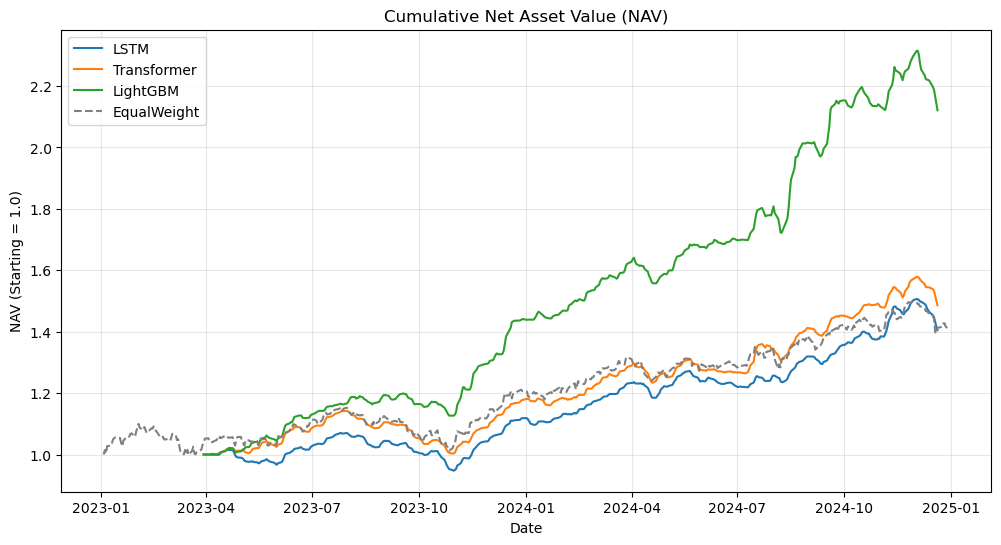

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(nav_lstm.index, nav_lstm.values, label="LSTM")
plt.plot(nav_transformer.index, nav_transformer.values, label="Transformer")
plt.plot(nav_lgbm.index, nav_lgbm.values, label="LightGBM")
plt.plot(nav_eq.index, nav_eq.values, label="EqualWeight", linestyle="--", color="gray")

plt.title("Cumulative Net Asset Value (NAV)")
plt.xlabel("Date")
plt.ylabel("NAV (Starting = 1.0)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

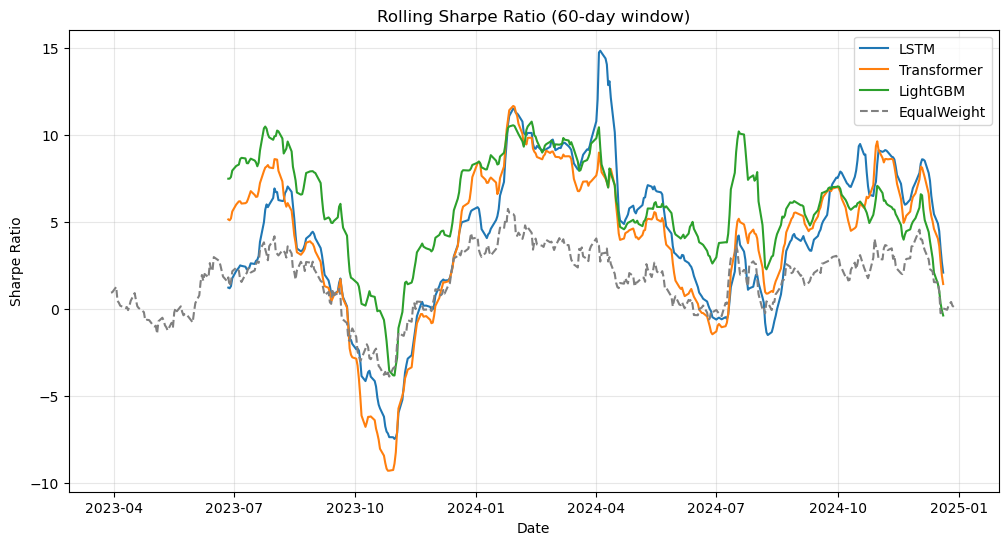

In [ ]:
import pandas as pd
import numpy as np

def rolling_sharpe(nav, window=60):  # 60 trading days ≈ 3 months
    returns = nav.pct_change().dropna()
    roll_mean = returns.rolling(window).mean()
    roll_std = returns.rolling(window).std()
    return (roll_mean / roll_std) * np.sqrt(252)  # annualized

plt.figure(figsize=(12,6))
plt.plot(rolling_sharpe(nav_lstm), label="LSTM")
plt.plot(rolling_sharpe(nav_transformer), label="Transformer")
plt.plot(rolling_sharpe(nav_lgbm), label="LightGBM")
plt.plot(rolling_sharpe(nav_eq), label="EqualWeight", linestyle="--", color="gray")

plt.title("Rolling Sharpe Ratio (60-day window)")
plt.xlabel("Date")
plt.ylabel("Sharpe Ratio")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

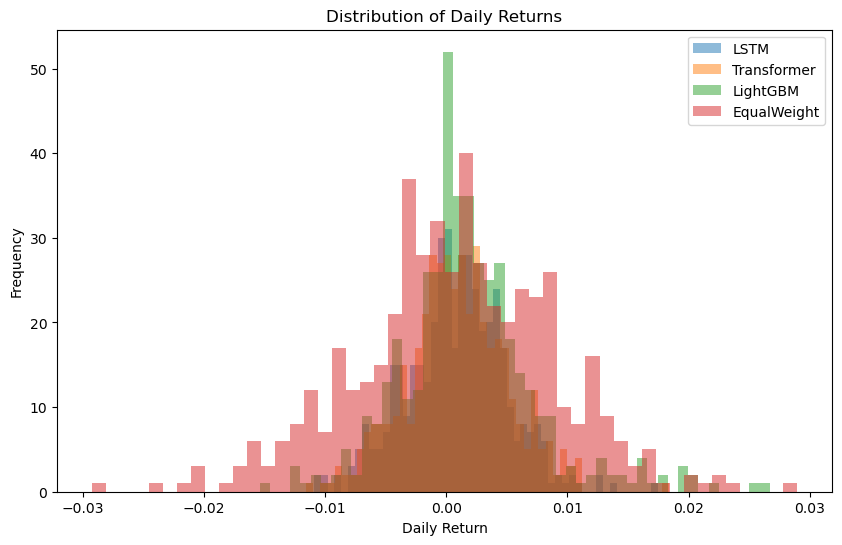

In [ ]:
plt.figure(figsize=(10,6))
plt.hist(nav_lstm.pct_change().dropna(), bins=50, alpha=0.5, label="LSTM")
plt.hist(nav_transformer.pct_change().dropna(), bins=50, alpha=0.5, label="Transformer")
plt.hist(nav_lgbm.pct_change().dropna(), bins=50, alpha=0.5, label="LightGBM")
plt.hist(nav_eq.pct_change().dropna(), bins=50, alpha=0.5, label="EqualWeight")

plt.title("Distribution of Daily Returns")
plt.xlabel("Daily Return")
plt.ylabel("Frequency")
plt.legend()
plt.show()

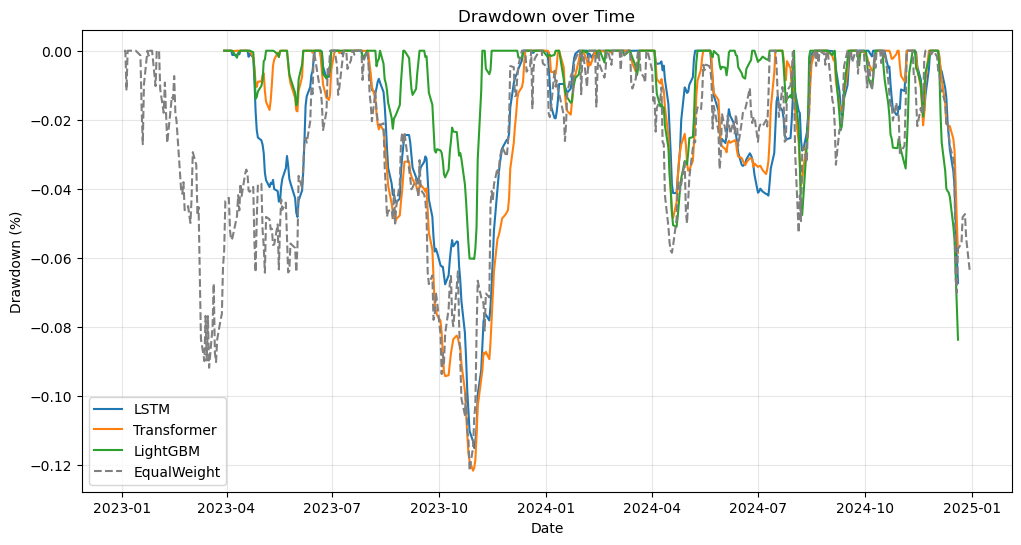

In [ ]:
def compute_drawdown(nav):
    cum_max = nav.cummax()
    drawdown = (nav - cum_max) / cum_max
    return drawdown

plt.figure(figsize=(12,6))
plt.plot(compute_drawdown(nav_lstm), label="LSTM")
plt.plot(compute_drawdown(nav_transformer), label="Transformer")
plt.plot(compute_drawdown(nav_lgbm), label="LightGBM")
plt.plot(compute_drawdown(nav_eq), label="EqualWeight", linestyle="--", color="gray")

plt.title("Drawdown over Time")
plt.xlabel("Date")
plt.ylabel("Drawdown (%)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Failure Analysis

In this section, we perform a comprehensive failure analysis of our three models:
1. **Classification Accuracy & Confusion Matrices**
2. **Model Agreement & Disagreement Analysis**
3. **Confidence Analysis on Failures**
4. **Temporal Failure Patterns**
5. **Failure by Market Conditions**
6. **Per-Class Performance Analysis**


## 1. Generate Predictions for All Test Samples

First, we'll generate predictions and probabilities for all samples in the test set.


In [10]:
data = np.load("data/lstm_evaluate.npz", allow_pickle=True)

In [11]:
import torch
import numpy as np
from tqdm import tqdm

# Load test data
data = np.load("data/lstm_evaluate.npz", allow_pickle=True)
X_test = data["X"]
y_test = data["y"]
dates_test = data["dates"]
tickers_test = data["tickers"]

print(f"Generating predictions for {len(X_test)} samples...")

# Helper functions for batch predictions
def get_all_predictions_lstm(X, model, device="cuda", batch_size=256):
    model.eval()
    preds, probs_all = [], []
    
    with torch.no_grad():
        for i in tqdm(range(0, len(X), batch_size), desc="LSTM"):
            batch = torch.tensor(X[i:i+batch_size], dtype=torch.float32, device=device)
            logits = model(batch)
            probs = torch.softmax(logits, dim=1).cpu().numpy()
            preds.extend(np.argmax(probs, axis=1))
            probs_all.extend(probs)
    
    return np.array(preds), np.array(probs_all)

def get_all_predictions_transformer(X, model, device="cuda", batch_size=256):
    model.eval()
    preds, probs_all = [], []
    
    with torch.no_grad():
        for i in tqdm(range(0, len(X), batch_size), desc="Transformer"):
            batch = torch.tensor(X[i:i+batch_size], dtype=torch.float32, device=device)
            logits = model(batch)
            probs = torch.softmax(logits, dim=1).cpu().numpy()
            preds.extend(np.argmax(probs, axis=1))
            probs_all.extend(probs)
    
    return np.array(preds), np.array(probs_all)

def get_all_predictions_lgbm(X, model, batch_size=1000):
    preds, probs_all = [], []
    X_flat = X.reshape(len(X), -1)
    
    for i in tqdm(range(0, len(X_flat), batch_size), desc="LightGBM"):
        batch = X_flat[i:i+batch_size]
        probs = model.predict(batch)
        preds.extend(np.argmax(probs, axis=1))
        probs_all.extend(probs)
    
    return np.array(preds), np.array(probs_all)

# Generate all predictions
lstm_preds, lstm_probs = get_all_predictions_lstm(X_test, lstm_model, device=device)
transformer_preds, transformer_probs = get_all_predictions_transformer(X_test, transformer_model, device=device)
lgbm_preds, lgbm_probs = get_all_predictions_lgbm(X_test, lgbm_model)

print("\n✅ Predictions generated!")
print(f"LSTM predictions shape: {lstm_preds.shape}, probs shape: {lstm_probs.shape}")
print(f"Transformer predictions shape: {transformer_preds.shape}, probs shape: {transformer_probs.shape}")
print(f"LightGBM predictions shape: {lgbm_preds.shape}, probs shape: {lgbm_probs.shape}")


Generating predictions for 218129 samples...


LightGBM: 100%|██████████| 219/219 [00:01<00:00, 153.86it/s]



✅ Predictions generated!
LSTM predictions shape: (218129,), probs shape: (218129, 3)
Transformer predictions shape: (218129,), probs shape: (218129, 3)
LightGBM predictions shape: (218129,), probs shape: (218129, 3)


## 2. Classification Accuracy & Confusion Matrices

Calculate overall accuracy and visualize confusion matrices to understand classification errors.


In [13]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate accuracies
lstm_acc = accuracy_score(y_test, lstm_preds)
transformer_acc = accuracy_score(y_test, transformer_preds)
lgbm_acc = accuracy_score(y_test, lgbm_preds)

print("=" * 60)
print("CLASSIFICATION ACCURACY")
print("=" * 60)
print(f"LSTM Accuracy:        {lstm_acc:.4f} ({lstm_acc*100:.2f}%)")
print(f"Transformer Accuracy: {transformer_acc:.4f} ({transformer_acc*100:.2f}%)")
print(f"LightGBM Accuracy:    {lgbm_acc:.4f} ({lgbm_acc*100:.2f}%)")
print("=" * 60)

# Classification reports
class_names = ['Down (0)', 'Flat (1)', 'Up (2)']

print("\n" + "=" * 60)
print("LSTM CLASSIFICATION REPORT")
print("=" * 60)
print(classification_report(y_test, lstm_preds, target_names=class_names))

print("\n" + "=" * 60)
print("TRANSFORMER CLASSIFICATION REPORT")
print("=" * 60)
print(classification_report(y_test, transformer_preds, target_names=class_names))

print("\n" + "=" * 60)
print("LIGHTGBM CLASSIFICATION REPORT")
print("=" * 60)
print(classification_report(y_test, lgbm_preds, target_names=class_names))


CLASSIFICATION ACCURACY
LSTM Accuracy:        0.3681 (36.81%)
Transformer Accuracy: 0.3552 (35.52%)
LightGBM Accuracy:    0.4153 (41.53%)

LSTM CLASSIFICATION REPORT
              precision    recall  f1-score   support

    Down (0)       0.31      0.33      0.32     61590
    Flat (1)       0.41      0.43      0.42     79866
      Up (2)       0.37      0.33      0.35     76673

    accuracy                           0.37    218129
   macro avg       0.36      0.36      0.36    218129
weighted avg       0.37      0.37      0.37    218129


TRANSFORMER CLASSIFICATION REPORT
              precision    recall  f1-score   support

    Down (0)       0.30      0.34      0.32     61590
    Flat (1)       0.40      0.34      0.37     79866
      Up (2)       0.37      0.38      0.37     76673

    accuracy                           0.36    218129
   macro avg       0.36      0.35      0.35    218129
weighted avg       0.36      0.36      0.36    218129


LIGHTGBM CLASSIFICATION REPORT
     

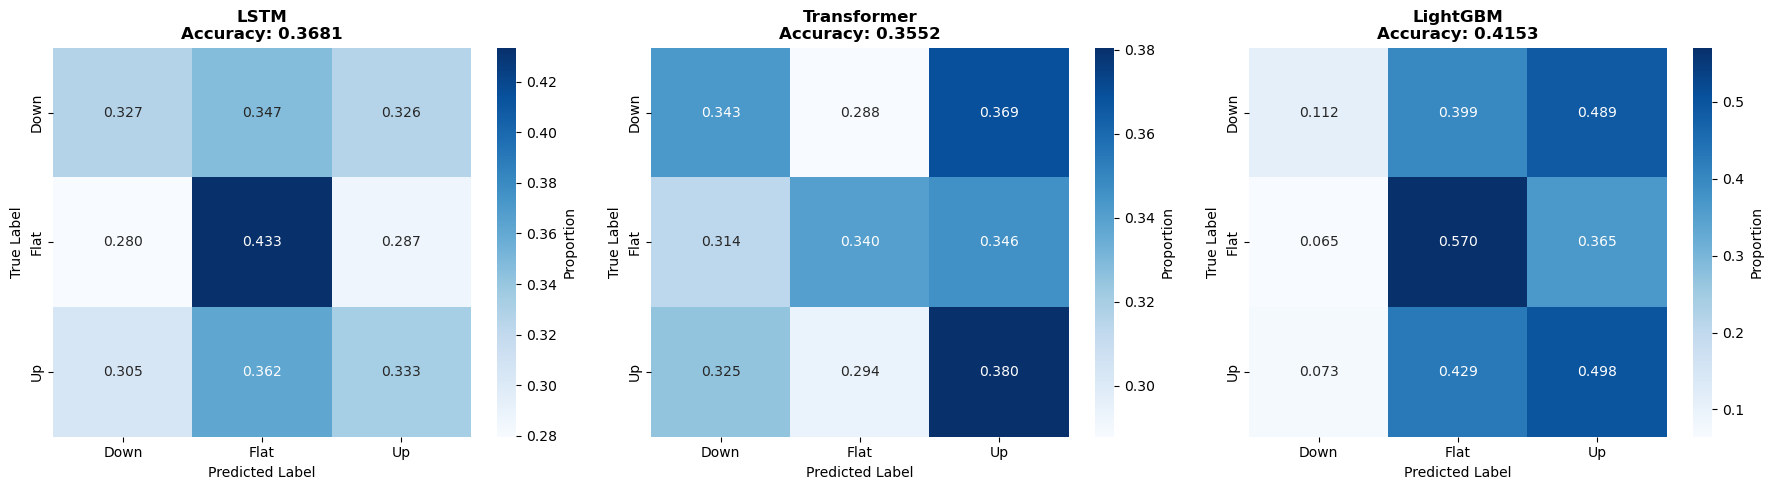


RAW CONFUSION MATRICES (counts)

LSTM:
           Pred Down  Pred Flat  Pred Up
True Down     20114      21396     20080
True Flat     22329      34621     22916
True Up       23358      27761     25554

Transformer:
           Pred Down  Pred Flat  Pred Up
True Down     21132      17726     22732
True Flat     25060      27178     27628
True Up       24944      22559     29170

LightGBM:
           Pred Down  Pred Flat  Pred Up
True Down      6880      24584     30126
True Flat      5155      45558     29153
True Up        5594      32924     38155


In [14]:
# Confusion Matrices
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

models = [
    ("LSTM", lstm_preds, lstm_acc),
    ("Transformer", transformer_preds, transformer_acc),
    ("LightGBM", lgbm_preds, lgbm_acc)
]

for idx, (name, preds, acc) in enumerate(models):
    cm = confusion_matrix(y_test, preds)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    sns.heatmap(cm_normalized, annot=True, fmt='.3f', cmap='Blues', 
                xticklabels=['Down', 'Flat', 'Up'],
                yticklabels=['Down', 'Flat', 'Up'],
                ax=axes[idx], cbar_kws={'label': 'Proportion'})
    
    axes[idx].set_title(f'{name}\nAccuracy: {acc:.4f}', fontsize=12, fontweight='bold')
    axes[idx].set_ylabel('True Label')
    axes[idx].set_xlabel('Predicted Label')

plt.tight_layout()
plt.show()

# Raw confusion matrices
print("\n" + "=" * 60)
print("RAW CONFUSION MATRICES (counts)")
print("=" * 60)
for name, preds, _ in models:
    cm = confusion_matrix(y_test, preds)
    print(f"\n{name}:")
    print("           Pred Down  Pred Flat  Pred Up")
    print(f"True Down    {cm[0,0]:6d}     {cm[0,1]:6d}    {cm[0,2]:6d}")
    print(f"True Flat    {cm[1,0]:6d}     {cm[1,1]:6d}    {cm[1,2]:6d}")
    print(f"True Up      {cm[2,0]:6d}     {cm[2,1]:6d}    {cm[2,2]:6d}")


## 3. Model Agreement & Disagreement Analysis

Analyze when models agree or disagree, and when they're collectively right or wrong.


In [15]:
# Create agreement indicators
lstm_correct = (lstm_preds == y_test)
transformer_correct = (transformer_preds == y_test)
lgbm_correct = (lgbm_preds == y_test)

all_agree_correct = lstm_correct & transformer_correct & lgbm_correct
all_agree_wrong = (~lstm_correct) & (~transformer_correct) & (~lgbm_correct)
at_least_one_correct = lstm_correct | transformer_correct | lgbm_correct

# Agreement patterns
all_models_agree = (lstm_preds == transformer_preds) & (transformer_preds == lgbm_preds)
two_models_agree = ((lstm_preds == transformer_preds) & (transformer_preds != lgbm_preds)) | \
                   ((lstm_preds == lgbm_preds) & (lstm_preds != transformer_preds)) | \
                   ((transformer_preds == lgbm_preds) & (transformer_preds != lstm_preds))
all_disagree = (lstm_preds != transformer_preds) & (transformer_preds != lgbm_preds) & (lstm_preds != lgbm_preds)

print("=" * 60)
print("MODEL AGREEMENT ANALYSIS")
print("=" * 60)
print(f"Total samples: {len(y_test):,}\n")

print("Agreement Patterns:")
print(f"  All 3 models agree:      {all_models_agree.sum():,} ({all_models_agree.mean()*100:.2f}%)")
print(f"  Exactly 2 models agree:  {two_models_agree.sum():,} ({two_models_agree.mean()*100:.2f}%)")
print(f"  All 3 models disagree:   {all_disagree.sum():,} ({all_disagree.mean()*100:.2f}%)")

print("\nCorrectness Patterns:")
print(f"  All 3 correct:           {all_agree_correct.sum():,} ({all_agree_correct.mean()*100:.2f}%)")
print(f"  All 3 wrong:             {all_agree_wrong.sum():,} ({all_agree_wrong.mean()*100:.2f}%)")
print(f"  At least 1 correct:      {at_least_one_correct.sum():,} ({at_least_one_correct.mean()*100:.2f}%)")

print("\nWhen all 3 agree:")
agree_correct = all_models_agree & lstm_correct
agree_wrong = all_models_agree & (~lstm_correct)
print(f"  Correct: {agree_correct.sum():,} ({agree_correct.sum()/all_models_agree.sum()*100:.2f}% of agreements)")
print(f"  Wrong:   {agree_wrong.sum():,} ({agree_wrong.sum()/all_models_agree.sum()*100:.2f}% of agreements)")

print("\nPairwise Agreement:")
lstm_trans_agree = (lstm_preds == transformer_preds).mean()
lstm_lgbm_agree = (lstm_preds == lgbm_preds).mean()
trans_lgbm_agree = (transformer_preds == lgbm_preds).mean()

print(f"  LSTM ↔ Transformer:      {lstm_trans_agree*100:.2f}%")
print(f"  LSTM ↔ LightGBM:         {lstm_lgbm_agree*100:.2f}%")
print(f"  Transformer ↔ LightGBM:  {trans_lgbm_agree*100:.2f}%")

print("\nIndividual Model Performance:")
print(f"  LSTM correct:            {lstm_correct.sum():,} ({lstm_correct.mean()*100:.2f}%)")
print(f"  Transformer correct:     {transformer_correct.sum():,} ({transformer_correct.mean()*100:.2f}%)")
print(f"  LightGBM correct:        {lgbm_correct.sum():,} ({lgbm_correct.mean()*100:.2f}%)")
print("=" * 60)


MODEL AGREEMENT ANALYSIS
Total samples: 218,129

Agreement Patterns:
  All 3 models agree:      44,979 (20.62%)
  Exactly 2 models agree:  141,426 (64.84%)
  All 3 models disagree:   31,724 (14.54%)

Correctness Patterns:
  All 3 correct:           20,295 (9.30%)
  All 3 wrong:             65,330 (29.95%)
  At least 1 correct:      152,799 (70.05%)

When all 3 agree:
  Correct: 20,295 (45.12% of agreements)
  Wrong:   24,684 (54.88% of agreements)

Pairwise Agreement:
  LSTM ↔ Transformer:      37.63%
  LSTM ↔ LightGBM:         47.58%
  Transformer ↔ LightGBM:  41.49%

Individual Model Performance:
  LSTM correct:            80,289 (36.81%)
  Transformer correct:     77,480 (35.52%)
  LightGBM correct:        90,593 (41.53%)


## 4. Confidence Analysis on Failures

Analyze model confidence on correct vs incorrect predictions.


In [16]:
# Get max probability (confidence) for each prediction
lstm_confidence = np.max(lstm_probs, axis=1)
transformer_confidence = np.max(transformer_probs, axis=1)
lgbm_confidence = np.max(lgbm_probs, axis=1)

# Separate confidence for correct vs incorrect
models_data = [
    ("LSTM", lstm_confidence, lstm_correct),
    ("Transformer", transformer_confidence, transformer_correct),
    ("LightGBM", lgbm_confidence, lgbm_correct)
]

print("=" * 60)
print("CONFIDENCE ANALYSIS")
print("=" * 60)

for name, conf, correct in models_data:
    conf_correct = conf[correct]
    conf_wrong = conf[~correct]
    
    print(f"\n{name}:")
    print(f"  Avg confidence (correct):   {conf_correct.mean():.4f} ± {conf_correct.std():.4f}")
    print(f"  Avg confidence (incorrect): {conf_wrong.mean():.4f} ± {conf_wrong.std():.4f}")
    print(f"  Confidence difference:      {conf_correct.mean() - conf_wrong.mean():.4f}")
    
    # High confidence errors
    high_conf_threshold = 0.70
    high_conf_errors = (~correct) & (conf > high_conf_threshold)
    print(f"  High-confidence errors (>{high_conf_threshold}): {high_conf_errors.sum():,} ({high_conf_errors.sum()/len(conf)*100:.2f}%)")

print("=" * 60)


CONFIDENCE ANALYSIS

LSTM:
  Avg confidence (correct):   0.6652 ± 0.1527
  Avg confidence (incorrect): 0.6541 ± 0.1551
  Confidence difference:      0.0111
  High-confidence errors (>0.7): 51,336 (23.53%)

Transformer:
  Avg confidence (correct):   0.7444 ± 0.1752
  Avg confidence (incorrect): 0.7426 ± 0.1770
  Confidence difference:      0.0018
  High-confidence errors (>0.7): 80,896 (37.09%)

LightGBM:
  Avg confidence (correct):   0.4498 ± 0.0884
  Avg confidence (incorrect): 0.4276 ± 0.0691
  Confidence difference:      0.0222
  High-confidence errors (>0.7): 748 (0.34%)


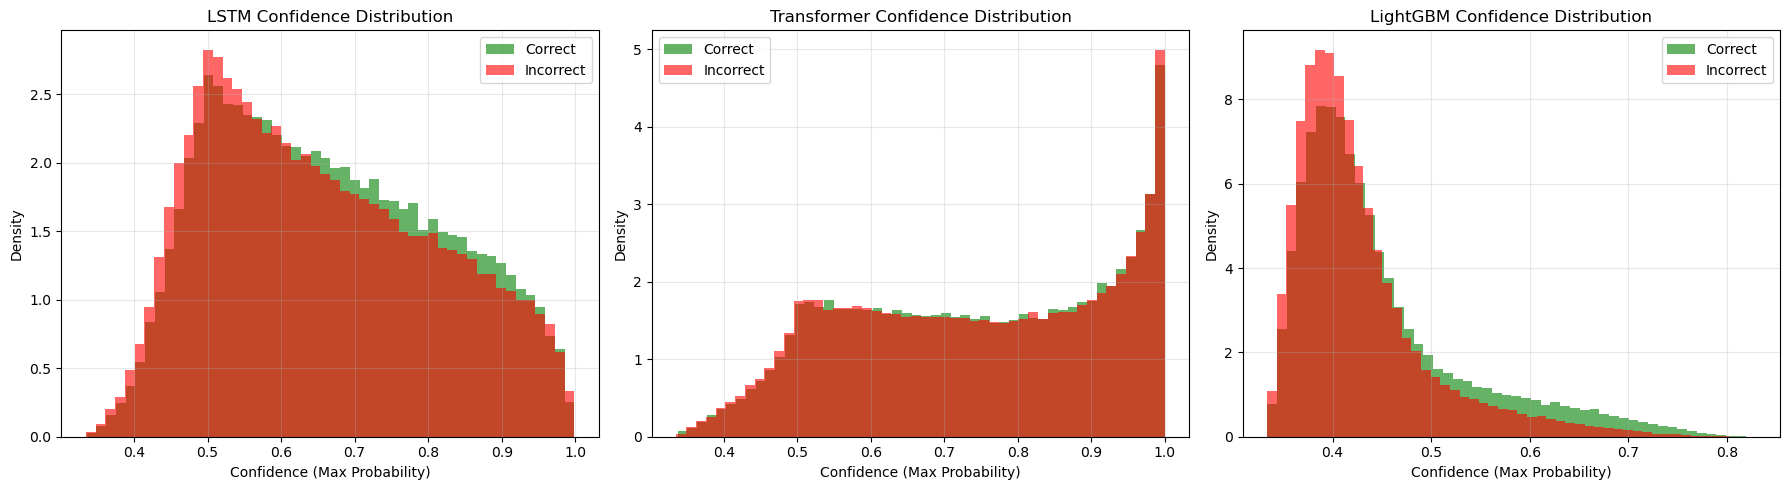

In [17]:
# Visualize confidence distributions
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, (name, conf, correct) in enumerate(models_data):
    axes[idx].hist(conf[correct], bins=50, alpha=0.6, label='Correct', color='green', density=True)
    axes[idx].hist(conf[~correct], bins=50, alpha=0.6, label='Incorrect', color='red', density=True)
    axes[idx].set_xlabel('Confidence (Max Probability)')
    axes[idx].set_ylabel('Density')
    axes[idx].set_title(f'{name} Confidence Distribution')
    axes[idx].legend()
    axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


## 5. Temporal Failure Patterns

Analyze how model accuracy changes over time.


In [18]:
# Create DataFrame with predictions and metadata
results_df = pd.DataFrame({
    'date': pd.to_datetime(dates_test),
    'ticker': tickers_test,
    'true_label': y_test,
    'lstm_pred': lstm_preds,
    'transformer_pred': transformer_preds,
    'lgbm_pred': lgbm_preds,
    'lstm_correct': lstm_correct,
    'transformer_correct': transformer_correct,
    'lgbm_correct': lgbm_correct,
    'lstm_conf': lstm_confidence,
    'transformer_conf': transformer_confidence,
    'lgbm_conf': lgbm_confidence
})

# Monthly accuracy
results_df['year_month'] = results_df['date'].dt.to_period('M')

monthly_acc = results_df.groupby('year_month').agg({
    'lstm_correct': 'mean',
    'transformer_correct': 'mean',
    'lgbm_correct': 'mean'
}).reset_index()

monthly_acc['year_month'] = monthly_acc['year_month'].astype(str)

print("=" * 60)
print("TEMPORAL ACCURACY ANALYSIS (Monthly)")
print("=" * 60)
print(monthly_acc.to_string(index=False))
print("=" * 60)


TEMPORAL ACCURACY ANALYSIS (Monthly)
year_month  lstm_correct  transformer_correct  lgbm_correct
   2023-03      0.381526             0.360442      0.421687
   2023-04      0.354048             0.352251      0.410378
   2023-05      0.392114             0.371760      0.427346
   2023-06      0.367707             0.355677      0.466342
   2023-07      0.364830             0.336774      0.410922
   2023-08      0.379716             0.352618      0.397926
   2023-09      0.345491             0.326653      0.274349
   2023-10      0.362196             0.363107      0.375125
   2023-11      0.382667             0.374667      0.459143
   2023-12      0.362600             0.354000      0.432500
   2024-01      0.358857             0.349810      0.439714
   2024-02      0.386200             0.362300      0.463100
   2024-03      0.374125             0.350030      0.444011
   2024-04      0.363455             0.341590      0.362820
   2024-05      0.386228             0.370985      0.416349
   

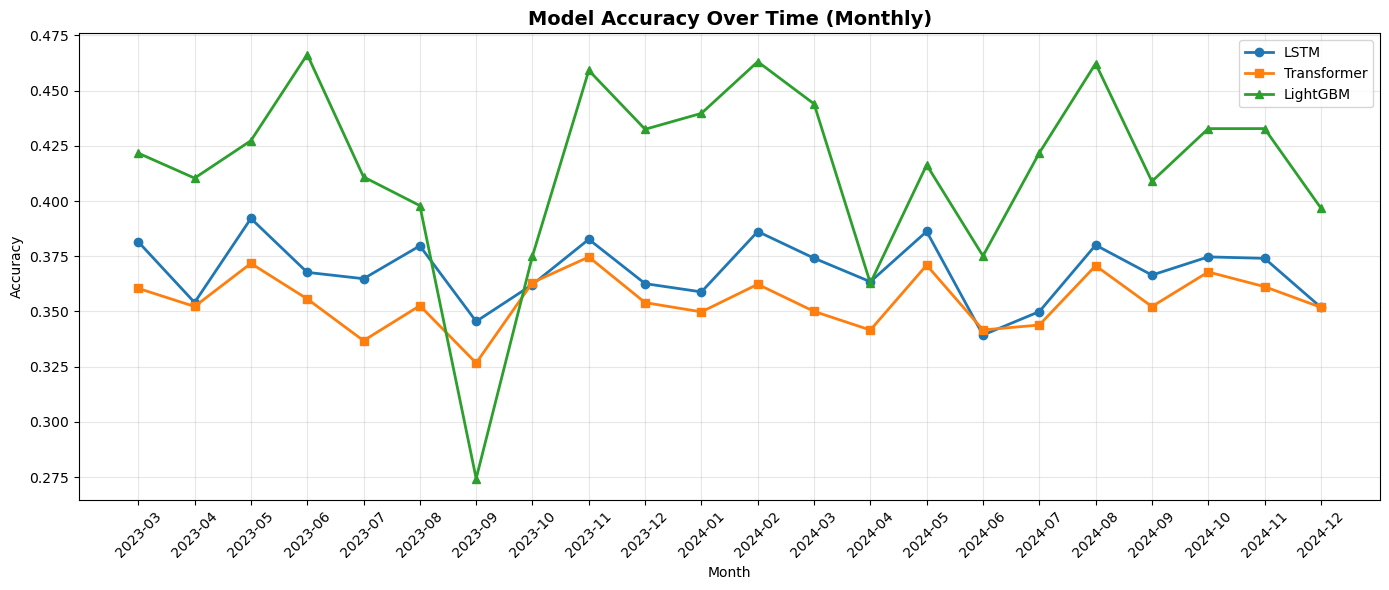


BEST AND WORST MONTHS

LSTM:
  Best:  2023-05 (0.3921)
  Worst: 2024-06 (0.3393)
  Range: 0.0528

TRANSFORMER:
  Best:  2023-11 (0.3747)
  Worst: 2023-09 (0.3267)
  Range: 0.0480

LGBM:
  Best:  2023-06 (0.4663)
  Worst: 2023-09 (0.2743)
  Range: 0.1920


In [19]:
# Plot temporal accuracy
plt.figure(figsize=(14, 6))
plt.plot(monthly_acc['year_month'], monthly_acc['lstm_correct'], marker='o', label='LSTM', linewidth=2)
plt.plot(monthly_acc['year_month'], monthly_acc['transformer_correct'], marker='s', label='Transformer', linewidth=2)
plt.plot(monthly_acc['year_month'], monthly_acc['lgbm_correct'], marker='^', label='LightGBM', linewidth=2)

plt.xlabel('Month')
plt.ylabel('Accuracy')
plt.title('Model Accuracy Over Time (Monthly)', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Find best and worst months for each model
print("\n" + "=" * 60)
print("BEST AND WORST MONTHS")
print("=" * 60)

for model_name in ['lstm_correct', 'transformer_correct', 'lgbm_correct']:
    best_month = monthly_acc.loc[monthly_acc[model_name].idxmax()]
    worst_month = monthly_acc.loc[monthly_acc[model_name].idxmin()]
    
    display_name = model_name.replace('_correct', '').upper()
    print(f"\n{display_name}:")
    print(f"  Best:  {best_month['year_month']} ({best_month[model_name]:.4f})")
    print(f"  Worst: {worst_month['year_month']} ({worst_month[model_name]:.4f})")
    print(f"  Range: {best_month[model_name] - worst_month[model_name]:.4f}")

print("=" * 60)


## 6. Per-Class Performance Analysis

Analyze model performance by true class label.


In [20]:
# Accuracy by true class
class_labels = {0: 'Down', 1: 'Flat', 2: 'Up'}

print("=" * 60)
print("ACCURACY BY TRUE CLASS")
print("=" * 60)

class_performance = []
for class_id, class_name in class_labels.items():
    mask = y_test == class_id
    n_samples = mask.sum()
    
    lstm_acc_class = lstm_correct[mask].mean()
    transformer_acc_class = transformer_correct[mask].mean()
    lgbm_acc_class = lgbm_correct[mask].mean()
    
    print(f"\nClass {class_id} ({class_name}) - {n_samples:,} samples:")
    print(f"  LSTM:        {lstm_acc_class:.4f} ({lstm_acc_class*100:.2f}%)")
    print(f"  Transformer: {transformer_acc_class:.4f} ({transformer_acc_class*100:.2f}%)")
    print(f"  LightGBM:    {lgbm_acc_class:.4f} ({lgbm_acc_class*100:.2f}%)")
    
    class_performance.append({
        'Class': class_name,
        'Samples': n_samples,
        'LSTM': lstm_acc_class,
        'Transformer': transformer_acc_class,
        'LightGBM': lgbm_acc_class
    })

print("=" * 60)

# Create summary dataframe
class_perf_df = pd.DataFrame(class_performance)
print("\nSummary Table:")
print(class_perf_df.to_string(index=False))


ACCURACY BY TRUE CLASS

Class 0 (Down) - 61,590 samples:
  LSTM:        0.3266 (32.66%)
  Transformer: 0.3431 (34.31%)
  LightGBM:    0.1117 (11.17%)

Class 1 (Flat) - 79,866 samples:
  LSTM:        0.4335 (43.35%)
  Transformer: 0.3403 (34.03%)
  LightGBM:    0.5704 (57.04%)

Class 2 (Up) - 76,673 samples:
  LSTM:        0.3333 (33.33%)
  Transformer: 0.3804 (38.04%)
  LightGBM:    0.4976 (49.76%)

Summary Table:
Class  Samples     LSTM  Transformer  LightGBM
 Down    61590 0.326579     0.343108  0.111706
 Flat    79866 0.433489     0.340295  0.570430
   Up    76673 0.333286     0.380447  0.497633


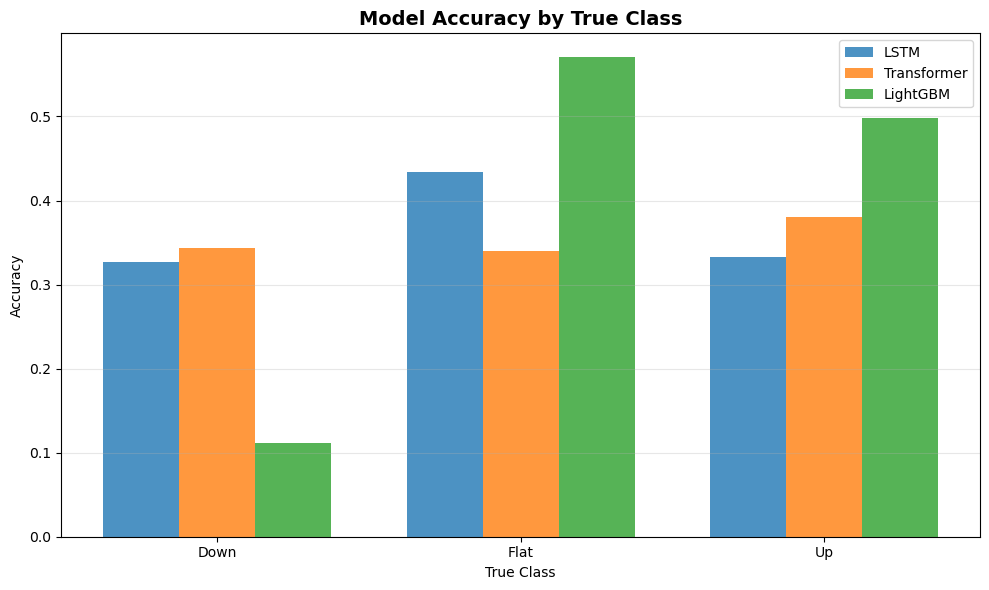

In [21]:
# Visualize per-class accuracy
fig, ax = plt.subplots(figsize=(10, 6))

x = np.arange(len(class_labels))
width = 0.25

ax.bar(x - width, class_perf_df['LSTM'], width, label='LSTM', alpha=0.8)
ax.bar(x, class_perf_df['Transformer'], width, label='Transformer', alpha=0.8)
ax.bar(x + width, class_perf_df['LightGBM'], width, label='LightGBM', alpha=0.8)

ax.set_xlabel('True Class')
ax.set_ylabel('Accuracy')
ax.set_title('Model Accuracy by True Class', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(class_perf_df['Class'])
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()


## 7. Failure Mode Analysis

Identify the most common types of misclassifications.


In [22]:
# Analyze error patterns
def get_error_patterns(y_true, y_pred, model_name):
    errors = y_true != y_pred
    error_df = pd.DataFrame({
        'true': y_true[errors],
        'pred': y_pred[errors]
    })
    
    error_counts = error_df.groupby(['true', 'pred']).size().reset_index(name='count')
    error_counts['percentage'] = error_counts['count'] / errors.sum() * 100
    error_counts = error_counts.sort_values('count', ascending=False)
    
    # Map to labels
    error_counts['true_label'] = error_counts['true'].map(class_labels)
    error_counts['pred_label'] = error_counts['pred'].map(class_labels)
    
    return error_counts

print("=" * 60)
print("MOST COMMON ERROR PATTERNS")
print("=" * 60)

for model_name, preds in [('LSTM', lstm_preds), ('Transformer', transformer_preds), ('LightGBM', lgbm_preds)]:
    print(f"\n{model_name}:")
    error_patterns = get_error_patterns(y_test, preds, model_name)
    
    for _, row in error_patterns.iterrows():
        print(f"  {row['true_label']:>4} → {row['pred_label']:>4}: {row['count']:>6,} errors ({row['percentage']:>5.2f}%)")
    
print("=" * 60)


MOST COMMON ERROR PATTERNS

LSTM:
    Up → Flat: 27,761 errors (20.14%)
    Up → Down: 23,358 errors (16.95%)
  Flat →   Up: 22,916 errors (16.63%)
  Flat → Down: 22,329 errors (16.20%)
  Down → Flat: 21,396 errors (15.52%)
  Down →   Up: 20,080 errors (14.57%)

Transformer:
  Flat →   Up: 27,628 errors (19.64%)
  Flat → Down: 25,060 errors (17.82%)
    Up → Down: 24,944 errors (17.73%)
  Down →   Up: 22,732 errors (16.16%)
    Up → Flat: 22,559 errors (16.04%)
  Down → Flat: 17,726 errors (12.60%)

LightGBM:
    Up → Flat: 32,924 errors (25.82%)
  Down →   Up: 30,126 errors (23.62%)
  Flat →   Up: 29,153 errors (22.86%)
  Down → Flat: 24,584 errors (19.28%)
    Up → Down:  5,594 errors ( 4.39%)
  Flat → Down:  5,155 errors ( 4.04%)


## 8. Hard Examples Analysis

Identify specific examples where all models fail.


In [23]:
# Find samples where all models are wrong
all_wrong_mask = all_agree_wrong

print("=" * 60)
print("SAMPLES WHERE ALL 3 MODELS FAIL")
print("=" * 60)
print(f"Total samples where all fail: {all_wrong_mask.sum():,} ({all_wrong_mask.mean()*100:.2f}%)\n")

# Analyze these hard examples
hard_examples = results_df[all_wrong_mask].copy()

# Class distribution of hard examples
print("Class distribution of hard examples:")
hard_class_dist = hard_examples['true_label'].value_counts().sort_index()
for class_id, count in hard_class_dist.items():
    print(f"  Class {class_id} ({class_labels[class_id]}): {count:,} ({count/len(hard_examples)*100:.2f}%)")

# Most common prediction when all are wrong
print("\nMost common (wrong) predictions when all fail:")
pred_counts = hard_examples['lstm_pred'].value_counts()
for pred_class, count in pred_counts.items():
    print(f"  Predicted {class_labels[pred_class]}: {count:,} ({count/len(hard_examples)*100:.2f}%)")

# Sample some hard examples
print("\nSample of hard examples (first 10):")
sample_hard = hard_examples.head(10)[['date', 'ticker', 'true_label', 'lstm_pred', 'transformer_pred', 'lgbm_pred']]
sample_hard['true_label'] = sample_hard['true_label'].map(class_labels)
sample_hard['lstm_pred'] = sample_hard['lstm_pred'].map(class_labels)
sample_hard['transformer_pred'] = sample_hard['transformer_pred'].map(class_labels)
sample_hard['lgbm_pred'] = sample_hard['lgbm_pred'].map(class_labels)
print(sample_hard.to_string(index=False))

print("=" * 60)


SAMPLES WHERE ALL 3 MODELS FAIL
Total samples where all fail: 65,330 (29.95%)

Class distribution of hard examples:
  Class 0 (Down): 25,928 (39.69%)
  Class 1 (Flat): 19,421 (29.73%)
  Class 2 (Up): 19,981 (30.58%)

Most common (wrong) predictions when all fail:
  Predicted Flat: 26,229 (40.15%)
  Predicted Up: 22,586 (34.57%)
  Predicted Down: 16,515 (25.28%)

Sample of hard examples (first 10):
      date ticker true_label lstm_pred transformer_pred lgbm_pred
2023-04-13   HOLX       Down      Flat               Up        Up
2023-04-19   HOLX       Flat      Down               Up        Up
2023-04-20   HOLX       Flat      Down             Down      Down
2023-04-24   HOLX         Up      Down             Flat      Down
2023-04-26   HOLX       Flat      Down             Down        Up
2023-05-09   HOLX       Down      Flat             Flat      Flat
2023-05-22   HOLX       Down      Flat               Up      Flat
2023-05-23   HOLX       Down      Flat               Up      Flat
2023-

## 9. Ticker-Specific Performance

Identify which stocks are easiest and hardest to predict.


In [ ]:
# Aggregate performance by ticker
ticker_performance = results_df.groupby('ticker').agg({
    'lstm_correct': 'mean',
    'transformer_correct': 'mean',
    'lgbm_correct': 'mean',
    'true_label': 'count'
}).rename(columns={'true_label': 'n_samples'})

ticker_performance['avg_accuracy'] = ticker_performance[['lstm_correct', 'transformer_correct', 'lgbm_correct']].mean(axis=1)
ticker_performance = ticker_performance.sort_values('avg_accuracy')

print("=" * 60)
print("TICKER-SPECIFIC PERFORMANCE")
print("=" * 60)

print("\n10 HARDEST STOCKS TO PREDICT (Lowest Average Accuracy):")
print(ticker_performance.head(10).to_string())

print("\n\n10 EASIEST STOCKS TO PREDICT (Highest Average Accuracy):")
print(ticker_performance.tail(10).to_string())

print("\n\nStatistics:")
print(f"  Best ticker avg accuracy:  {ticker_performance['avg_accuracy'].max():.4f}")
print(f"  Worst ticker avg accuracy: {ticker_performance['avg_accuracy'].min():.4f}")
print(f"  Mean ticker avg accuracy:  {ticker_performance['avg_accuracy'].mean():.4f}")
print(f"  Std dev:                   {ticker_performance['avg_accuracy'].std():.4f}")

print("=" * 60)


TICKER-SPECIFIC PERFORMANCE

🔴 10 HARDEST STOCKS TO PREDICT (Lowest Average Accuracy):
        lstm_correct  transformer_correct  lgbm_correct  n_samples  avg_accuracy
ticker                                                                          
HSY         0.288991             0.284404      0.334862        436      0.302752
INCY        0.316514             0.295872      0.339450        436      0.317278
HCA         0.277523             0.341743      0.348624        436      0.322630
VLTO        0.374332             0.219251      0.385027        187      0.326203
REG         0.314220             0.307339      0.360092        436      0.327217
V           0.323394             0.293578      0.369266        436      0.328746
CMS         0.318807             0.293578      0.376147        436      0.329511
NXPI        0.298165             0.350917      0.341743        436      0.330275
VLO         0.332569             0.307339      0.350917        436      0.330275
GM          0.318807  

## 10. Ensemble Analysis

Explore if combining model predictions could improve performance.


In [25]:
# Create simple ensemble predictions

# Strategy 1: Majority vote
def majority_vote(pred1, pred2, pred3):
    from scipy import stats
    result = []
    for p1, p2, p3 in zip(pred1, pred2, pred3):
        votes = [p1, p2, p3]
        mode_result = stats.mode(votes, keepdims=True)
        result.append(mode_result.mode[0])
    return np.array(result)

# Strategy 2: Average probabilities
ensemble_avg_probs = (lstm_probs + transformer_probs + lgbm_probs) / 3
ensemble_avg_preds = np.argmax(ensemble_avg_probs, axis=1)

# Strategy 3: Weighted average (based on overall accuracy)
weights = np.array([lstm_acc, transformer_acc, lgbm_acc])
weights = weights / weights.sum()
ensemble_weighted_probs = (lstm_probs * weights[0] + 
                           transformer_probs * weights[1] + 
                           lgbm_probs * weights[2])
ensemble_weighted_preds = np.argmax(ensemble_weighted_probs, axis=1)

# Evaluate ensembles
ensemble_majority = majority_vote(lstm_preds, transformer_preds, lgbm_preds)

print("=" * 60)
print("ENSEMBLE PERFORMANCE")
print("=" * 60)

ensemble_methods = [
    ("Majority Vote", ensemble_majority),
    ("Average Probabilities", ensemble_avg_preds),
    ("Weighted Avg (by accuracy)", ensemble_weighted_preds)
]

print("\nIndividual Models (for reference):")
print(f"  LSTM:        {lstm_acc:.4f}")
print(f"  Transformer: {transformer_acc:.4f}")
print(f"  LightGBM:    {lgbm_acc:.4f}")

print("\nEnsemble Methods:")
for name, preds in ensemble_methods:
    acc = accuracy_score(y_test, preds)
    improvement_over_best = acc - lgbm_acc
    print(f"  {name:30s}: {acc:.4f} (Δ from best: {improvement_over_best:+.4f})")

print("=" * 60)

# Detailed report for best ensemble
best_ensemble_name = "Weighted Average"
best_ensemble_preds = ensemble_weighted_preds

print(f"\nDetailed Report for {best_ensemble_name} Ensemble:")
print(classification_report(y_test, best_ensemble_preds, target_names=class_names))


ENSEMBLE PERFORMANCE

Individual Models (for reference):
  LSTM:        0.3681
  Transformer: 0.3552
  LightGBM:    0.4153

Ensemble Methods:
  Majority Vote                 : 0.3866 (Δ from best: -0.0287)
  Average Probabilities         : 0.3789 (Δ from best: -0.0364)
  Weighted Avg (by accuracy)    : 0.3809 (Δ from best: -0.0344)

Detailed Report for Weighted Average Ensemble:
              precision    recall  f1-score   support

    Down (0)       0.32      0.32      0.32     61590
    Flat (1)       0.43      0.43      0.43     79866
      Up (2)       0.38      0.39      0.38     76673

    accuracy                           0.38    218129
   macro avg       0.38      0.38      0.38    218129
weighted avg       0.38      0.38      0.38    218129



## 11. Key Findings Summary

A comprehensive summary of the failure analysis.


In [26]:
print("=" * 80)
print(" " * 25 + "FAILURE ANALYSIS SUMMARY")
print("=" * 80)

print("\n📊 1. OVERALL PERFORMANCE")
print("-" * 80)
print(f"{'Model':<20} {'Accuracy':<15} {'Correct':<20} {'Incorrect':<20}")
print("-" * 80)
print(f"{'LSTM':<20} {lstm_acc:.4f} ({lstm_acc*100:.2f}%)  {lstm_correct.sum():>8,} ({lstm_correct.mean()*100:>5.2f}%)  {(~lstm_correct).sum():>8,} ({(~lstm_correct).mean()*100:>5.2f}%)")
print(f"{'Transformer':<20} {transformer_acc:.4f} ({transformer_acc*100:.2f}%)  {transformer_correct.sum():>8,} ({transformer_correct.mean()*100:>5.2f}%)  {(~transformer_correct).sum():>8,} ({(~transformer_correct).mean()*100:>5.2f}%)")
print(f"{'LightGBM':<20} {lgbm_acc:.4f} ({lgbm_acc*100:.2f}%)  {lgbm_correct.sum():>8,} ({lgbm_correct.mean()*100:>5.2f}%)  {(~lgbm_correct).sum():>8,} ({(~lgbm_correct).mean()*100:>5.2f}%)")

print("\n\n🤝 2. MODEL AGREEMENT INSIGHTS")
print("-" * 80)
print(f"• All 3 models agree on predictions: {all_models_agree.mean()*100:.2f}% of cases")
print(f"  → When they agree, they're correct: {agree_correct.sum()/all_models_agree.sum()*100:.2f}% of the time")
print(f"  → When they agree, they're wrong: {agree_wrong.sum()/all_models_agree.sum()*100:.2f}% of the time")
print(f"\n• All 3 models simultaneously fail: {all_agree_wrong.sum():,} cases ({all_agree_wrong.mean()*100:.2f}%)")
print(f"• At least one model is correct: {at_least_one_correct.sum():,} cases ({at_least_one_correct.mean()*100:.2f}%)")

print("\n\n🎯 3. CONFIDENCE ANALYSIS")
print("-" * 80)
for name, conf, correct in models_data:
    conf_correct_mean = conf[correct].mean()
    conf_wrong_mean = conf[~correct].mean()
    high_conf_errors = ((~correct) & (conf > 0.70)).sum()
    print(f"{name}:")
    print(f"  • Avg confidence when correct:   {conf_correct_mean:.4f}")
    print(f"  • Avg confidence when incorrect: {conf_wrong_mean:.4f}")
    print(f"  • Confidence gap:                {conf_correct_mean - conf_wrong_mean:.4f}")
    print(f"  • High-confidence errors (>0.70): {high_conf_errors:,}")

print("\n\n📉 4. CLASS-SPECIFIC PERFORMANCE")
print("-" * 80)
print(f"{'Class':<10} {'Samples':<12} {'LSTM Acc':<12} {'Trans Acc':<12} {'LGBM Acc':<12}")
print("-" * 80)
for _, row in class_perf_df.iterrows():
    print(f"{row['Class']:<10} {row['Samples']:<12,} {row['LSTM']:.4f}       {row['Transformer']:.4f}       {row['LightGBM']:.4f}")

print("\n\n❌ 5. MOST COMMON FAILURE MODES")
print("-" * 80)
for model_name, preds in [('LSTM', lstm_preds), ('Transformer', transformer_preds), ('LightGBM', lgbm_preds)]:
    error_patterns = get_error_patterns(y_test, preds, model_name)
    top_error = error_patterns.iloc[0]
    print(f"{model_name}: Most common error is predicting '{top_error['pred_label']}' when true is '{top_error['true_label']}'")
    print(f"         → {top_error['count']:,} cases ({top_error['percentage']:.2f}% of all errors)")

print("\n\n📈 6. TEMPORAL PATTERNS")
print("-" * 80)
for model_name in ['lstm_correct', 'transformer_correct', 'lgbm_correct']:
    best_month = monthly_acc.loc[monthly_acc[model_name].idxmax()]
    worst_month = monthly_acc.loc[monthly_acc[model_name].idxmin()]
    volatility = monthly_acc[model_name].std()
    display_name = model_name.replace('_correct', '').upper()
    print(f"{display_name}:")
    print(f"  • Best month:  {best_month['year_month']} ({best_month[model_name]:.4f})")
    print(f"  • Worst month: {worst_month['year_month']} ({worst_month[model_name]:.4f})")
    print(f"  • Volatility (std): {volatility:.4f}")

print("\n\n🎲 7. ENSEMBLE POTENTIAL")
print("-" * 80)
for name, preds in ensemble_methods:
    acc = accuracy_score(y_test, preds)
    improvement = acc - lgbm_acc
    symbol = "✓" if improvement > 0 else "✗"
    print(f"{symbol} {name:<30}: {acc:.4f} ({improvement:+.4f} vs. best single model)")

print("\n\n🔍 8. KEY INSIGHTS")
print("-" * 80)
print(f"• LightGBM is the strongest individual model ({lgbm_acc:.4f} accuracy)")
print(f"• {all_agree_wrong.sum():,} samples ({all_agree_wrong.mean()*100:.2f}%) are hard for ALL models")
print(f"• Models show highest agreement: {max(lstm_trans_agree, lstm_lgbm_agree, trans_lgbm_agree)*100:.2f}%")
print(f"• Ticker performance varies widely: {ticker_performance['avg_accuracy'].min():.4f} to {ticker_performance['avg_accuracy'].max():.4f}")
print(f"• Temporal performance shows {monthly_acc[['lstm_correct', 'transformer_correct', 'lgbm_correct']].std().mean():.4f} avg volatility")

# Determine if ensemble helps
best_ensemble_acc = max([accuracy_score(y_test, preds) for _, preds in ensemble_methods])
if best_ensemble_acc > lgbm_acc:
    print(f"• ✓ Ensemble methods improve over best single model by {best_ensemble_acc - lgbm_acc:.4f}")
else:
    print(f"• ✗ Ensemble methods do NOT improve over best single model")

print("\n" + "=" * 80)


                         FAILURE ANALYSIS SUMMARY

📊 1. OVERALL PERFORMANCE
--------------------------------------------------------------------------------
Model                Accuracy        Correct              Incorrect           
--------------------------------------------------------------------------------
LSTM                 0.3681 (36.81%)    80,289 (36.81%)   137,840 (63.19%)
Transformer          0.3552 (35.52%)    77,480 (35.52%)   140,649 (64.48%)
LightGBM             0.4153 (41.53%)    90,593 (41.53%)   127,536 (58.47%)


🤝 2. MODEL AGREEMENT INSIGHTS
--------------------------------------------------------------------------------
• All 3 models agree on predictions: 20.62% of cases
  → When they agree, they're correct: 45.12% of the time
  → When they agree, they're wrong: 54.88% of the time

• All 3 models simultaneously fail: 65,330 cases (29.95%)
• At least one model is correct: 152,799 cases (70.05%)


🎯 3. CONFIDENCE ANALYSIS
--------------------------------------

## 13. Export Results

Save detailed analysis results for reporting and future reference.


In [27]:
# Save detailed results
output_dir = "failure_analysis_results"
import os
os.makedirs(output_dir, exist_ok=True)

# 1. Save full results dataframe
results_df.to_csv(f"{output_dir}/all_predictions.csv", index=False)
print(f"✅ Saved all predictions to {output_dir}/all_predictions.csv")

# 2. Save hard examples (where all models fail)
hard_examples.to_csv(f"{output_dir}/hard_examples_all_fail.csv", index=False)
print(f"✅ Saved hard examples to {output_dir}/hard_examples_all_fail.csv")

# 3. Save ticker performance
ticker_performance.to_csv(f"{output_dir}/ticker_performance.csv")
print(f"✅ Saved ticker performance to {output_dir}/ticker_performance.csv")

# 4. Save monthly performance
monthly_acc.to_csv(f"{output_dir}/monthly_accuracy.csv", index=False)
print(f"✅ Saved monthly accuracy to {output_dir}/monthly_accuracy.csv")

# 5. Save confusion matrices
for model_name, preds, _ in models:
    cm = confusion_matrix(y_test, preds)
    cm_df = pd.DataFrame(cm, 
                         index=['True_Down', 'True_Flat', 'True_Up'],
                         columns=['Pred_Down', 'Pred_Flat', 'Pred_Up'])
    cm_df.to_csv(f"{output_dir}/confusion_matrix_{model_name.lower()}.csv")
    print(f"✅ Saved {model_name} confusion matrix")

# 6. Save summary statistics
summary_stats = {
    'metric': ['Accuracy', 'Total_Samples', 'Correct_Predictions', 'Wrong_Predictions',
               'Avg_Confidence_Correct', 'Avg_Confidence_Wrong', 'High_Conf_Errors'],
    'LSTM': [
        lstm_acc,
        len(y_test),
        lstm_correct.sum(),
        (~lstm_correct).sum(),
        lstm_confidence[lstm_correct].mean(),
        lstm_confidence[~lstm_correct].mean(),
        ((~lstm_correct) & (lstm_confidence > 0.70)).sum()
    ],
    'Transformer': [
        transformer_acc,
        len(y_test),
        transformer_correct.sum(),
        (~transformer_correct).sum(),
        transformer_confidence[transformer_correct].mean(),
        transformer_confidence[~transformer_correct].mean(),
        ((~transformer_correct) & (transformer_confidence > 0.70)).sum()
    ],
    'LightGBM': [
        lgbm_acc,
        len(y_test),
        lgbm_correct.sum(),
        (~lgbm_correct).sum(),
        lgbm_confidence[lgbm_correct].mean(),
        lgbm_confidence[~lgbm_correct].mean(),
        ((~lgbm_correct) & (lgbm_confidence > 0.70)).sum()
    ]
}
summary_df = pd.DataFrame(summary_stats)
summary_df.to_csv(f"{output_dir}/summary_statistics.csv", index=False)
print(f"✅ Saved summary statistics to {output_dir}/summary_statistics.csv")

print(f"\n📁 All results saved to '{output_dir}/' directory")


✅ Saved all predictions to failure_analysis_results/all_predictions.csv
✅ Saved hard examples to failure_analysis_results/hard_examples_all_fail.csv
✅ Saved ticker performance to failure_analysis_results/ticker_performance.csv
✅ Saved monthly accuracy to failure_analysis_results/monthly_accuracy.csv
✅ Saved LSTM confusion matrix
✅ Saved Transformer confusion matrix
✅ Saved LightGBM confusion matrix
✅ Saved summary statistics to failure_analysis_results/summary_statistics.csv

📁 All results saved to 'failure_analysis_results/' directory
